# Interpolation Demo: Zero-Stuffing + Low-Pass Filtering

**Mat Vallejo** | PhD Candidate in Sound Recording, McGill University

This demonstration illustrates the process of upsampling and interpolating a discrete-time signal by an integer factor **L** using a two-step approach:

1. **Zero-stuffing** (insertion of L-1 zeros between samples)
2. **Low-pass filtering** (anti-imaging filter)

The demo also shows the consequences of using an incorrectly designed anti-imaging filter.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Signal Processing Functions

In [3]:
# 1.) Generate signal

def generate_test_signal(fs, freq_1=80, freq_2=150, N=256):

    t = np.arange(N) / fs
    x = np.sin(2 * np.pi * freq_1 * t) + 0.75 * np.sin(2 * np.pi * freq_2 * t)
    return x, t

# 2.) Upsample signal by inserting L-1 zeros between each sample

def zero_stuff(x, L):

    y = np.zeros(len(x) * L)
    y[::L] = x
    return y

# 3.) Windowed-sinc low-pass (LP) filter with Hamming window
# Ideal LP filter has response h[n] = sinc(wc*n)

def design_sinc_lpf(cutoff, fs, numtaps=101):

    n = np.arange(numtaps) - numtaps // 2
    omega_c = 2 * np.pi * cutoff / fs
    h = np.sinc(omega_c * n / np.pi)
    h *= np.hamming(numtaps)
    h /= np.sum(h)  # Normalize to unity gain at DC
    return h

# 4.) Apply anti-imaging low-pass filter to zero-stuffed signal.

def apply_interpolation_filter(x_upsampled, fs_up, fs_orig, mode="correct"):

    L = int(fs_up / fs_orig)

    if mode == "naive":
        cutoff = 0.45 * fs_up  # Intentionally incorrect
    else:
        cutoff = 0.45 * fs_orig  # Safe

    h = design_sinc_lpf(cutoff, fs_up, numtaps=101)
    h *= L  # Scale filter by L for interpolation gain
    y = np.convolve(x_upsampled, h, mode='same')

    return y, h, cutoff

# 5.) Compute the spectrum

def compute_spectrum(x, fs):

    X = np.fft.fftshift(np.fft.fft(x))
    # X /= len(x)  # Normalize by length
    f = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs))
    return f, np.abs(X)

## Example 1: Naive Interpolation (Incorrect)

This example uses a naive low-pass filter with cutoff near the **upsampled** Nyquist frequency. This does **NOT** remove spectral images.

In [4]:
# Parameters
fs = 1000
L = 4
N = 256

# Generate signal
x, t = generate_test_signal(fs, 80, 150, N)

# Zero-stuff
x_up = zero_stuff(x, L)
fs_up = fs * L
t_up = np.arange(len(x_up)) / fs_up

# Apply naive filter
y_naive, h_naive, cutoff_naive = apply_interpolation_filter(x_up, fs_up, fs, mode="naive")

# Compute spectra
f_x, X = compute_spectrum(x, fs)
f_x_up, X_up = compute_spectrum(x_up, fs_up)
f_y_naive, Y_naive = compute_spectrum(y_naive, fs_up)

/tmp/ipython-input-1063359479.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


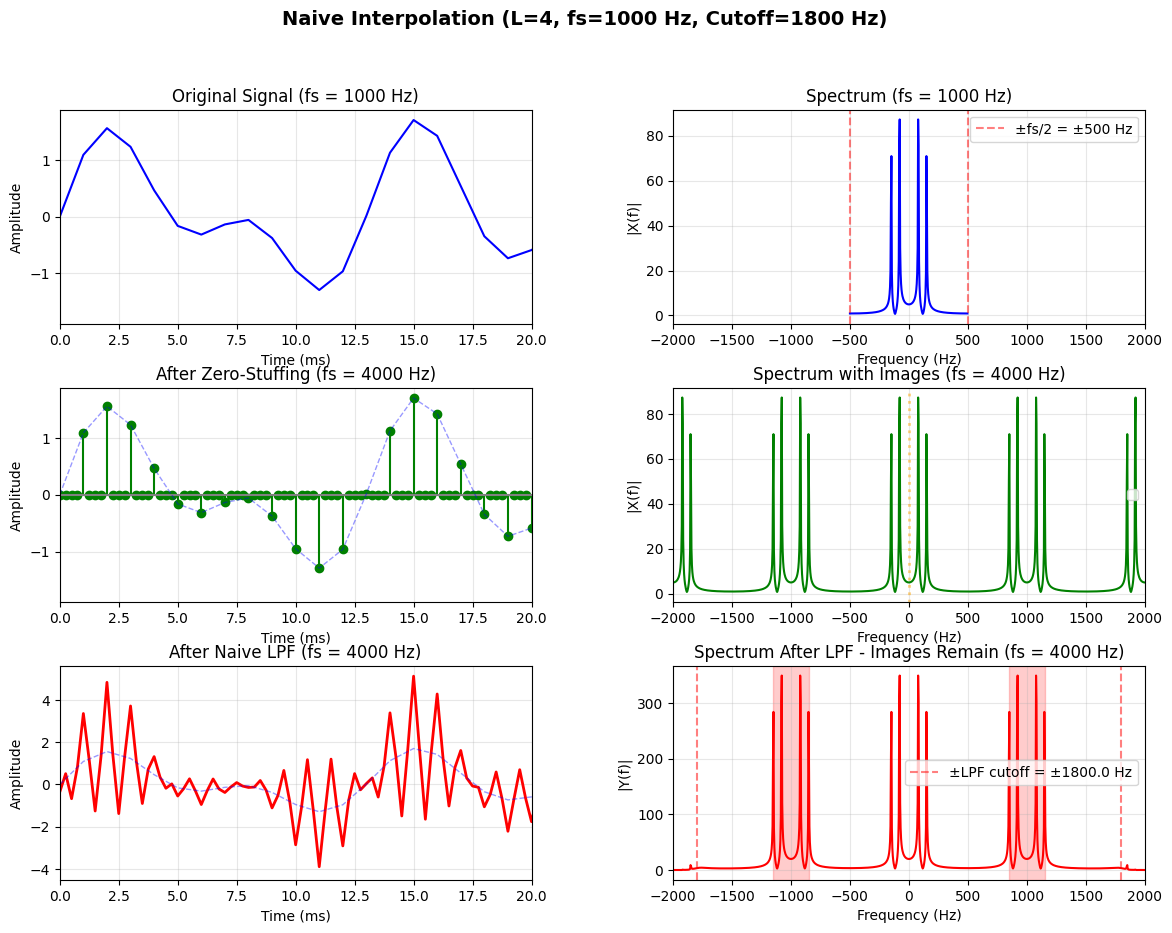

In [19]:
# @title
# Plot naive interpolation
fig = plt.figure(figsize=(14, 10))
fig.suptitle(f'Naive Interpolation (L={L}, fs={fs} Hz, Cutoff={cutoff_naive:.0f} Hz)',
             fontsize=14, fontweight='bold')

gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Original Signal
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t * 1000, x, 'b-', linewidth=1.5)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Original Signal (fs = {fs} Hz)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 20])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(f_x, X, 'b-', linewidth=1.5)
ax2.axvline(-fs/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label=f'±fs/2 = ±{fs/2:.0f} Hz')
ax2.axvline(fs/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|X(f)|')
ax2.set_title(f'Spectrum (fs = {fs} Hz)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([-fs_up/2, fs_up/2])

# Row 2: Zero-Stuffed Signal
ax3 = fig.add_subplot(gs[1, 0])
ax3.stem(t_up[:200] * 1000, x_up[:200], linefmt='g-',
         markerfmt='go', basefmt='gray')
ax3.plot(t * 1000, x, 'b--', alpha=0.4, linewidth=1)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Amplitude')
ax3.set_title(f'After Zero-Stuffing (fs = {fs_up} Hz)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 20])

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(f_x_up, X_up, 'g-', linewidth=1.5)
# Mark spectral images
ax4.axvline(-k*fs, color='orange', linestyle=':', alpha=0.5, linewidth=2)
ax4.axvline(0, color='orange', linestyle=':', alpha=0.5, linewidth=2)
ax4.axvline(k*fs, color='orange', linestyle=':', alpha=0.5, linewidth=2)
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('|X(f)|')
ax4.set_title(f'Spectrum with Images (fs = {fs_up} Hz)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xlim([-fs_up/2, fs_up/2])

# Row 3: Interpolated Signal
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(t_up[:200] * 1000, y_naive[:200], 'r-', linewidth=2)
ax5.plot(t * 1000, x, 'b--', alpha=0.4, linewidth=1)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Amplitude')
ax5.set_title(f'After Naive LPF (fs = {fs_up} Hz)')
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, 20])

ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(f_y_naive, Y_naive, 'r-', linewidth=1.5)
ax6.axvline(-cutoff_naive, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label=f'±LPF cutoff = ±{fs_up*0.45} Hz')
ax6.axvline(cutoff_naive, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
# ax6.axvspan(-cutoff_naive, cutoff_naive, alpha=0.1, color='orange', label=f'LPF passband = ±{cutoff_naive:.0f} Hz')
# Highlight remaining images
for k in [-1, 1]:
    ax6.axvspan(k*fs-150, k*fs+150, alpha=0.2, color='red')
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('|Y(f)|')
ax6.set_title(f'Spectrum After LPF - Images Remain (fs = {fs_up} Hz)')
ax6.grid(True, alpha=0.3)
ax6.legend()
ax6.set_xlim([-fs_up/2, fs_up/2])

plt.show()

### Naive Approach

The naive filter uses a cutoff frequency near the upsampled Nyquist frequency (L·fs/2). This fails to remove spectral images because:

- Original signal bandwidth: 0 to fs/2 = 500 Hz
- Zero-stuffing creates images centered at k·fs (±1000 Hz, ±2000 Hz, etc.)
- Naive filter cutoff: ~1800 Hz
- **Result**: Images at ±1000 Hz pass through the filter (red shaded regions)

The filter only attenuates content above its cutoff, but there was no signal content there to begin with. It does nothing useful.

## Example 2: Correct Interpolation

This example uses the proper low-pass filter with cutoff at the original Nyquist frequency. This removes spectral images.

In [6]:
# Apply correct filter (same signal)
y_correct, h_correct, cutoff_correct = apply_interpolation_filter(x_up, fs_up, fs, mode='correct')

# Compute spectrum
f_y_correct, Y_correct = compute_spectrum(y_correct, fs_up)

/tmp/ipython-input-1935558335.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


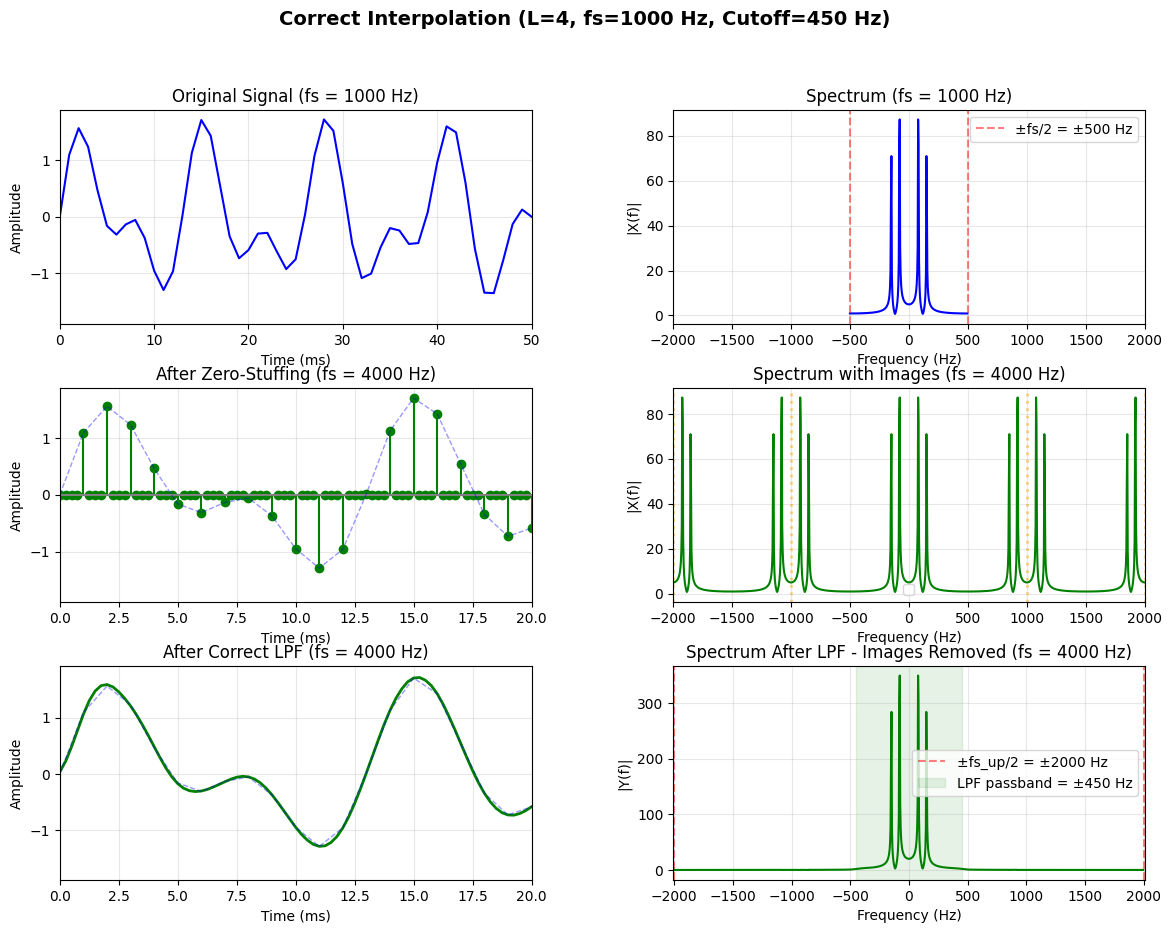

In [21]:
# @title
# Plot correct interpolation
fig = plt.figure(figsize=(14, 10))
fig.suptitle(f'Correct Interpolation (L={L}, fs={fs} Hz, Cutoff={cutoff_correct:.0f} Hz)',
             fontsize=14, fontweight='bold')

gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Original Signal
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t * 1000, x, 'b-', linewidth=1.5)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Original Signal (fs = {fs} Hz)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 50])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(f_x, X, 'b-', linewidth=1.5)
ax2.axvline(-fs/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label=f'±fs/2 = ±{fs/2:.0f} Hz')
ax2.axvline(fs/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('|X(f)|')
ax2.set_title(f'Spectrum (fs = {fs} Hz)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim([-fs_up/2, fs_up/2])

# Row 2: Zero-Stuffed Signal
ax3 = fig.add_subplot(gs[1, 0])
ax3.stem(t_up[:200] * 1000, x_up[:200], linefmt='g-',
         markerfmt='go', basefmt='gray')
ax3.plot(t * 1000, x, 'b--', alpha=0.4, linewidth=1)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Amplitude')
ax3.set_title(f'After Zero-Stuffing (fs = {fs_up} Hz)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 20])

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(f_x_up, X_up, 'g-', linewidth=1.5)
# Mark spectral images
for k in range(-L, L+1):
    if k != 0:
        ax4.axvline(k*fs, color='orange', linestyle=':', alpha=0.5, linewidth=2)
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('|X(f)|')
ax4.set_title(f'Spectrum with Images (fs = {fs_up} Hz)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xlim([-fs_up/2, fs_up/2])

# Row 3: Interpolated Signal
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(t_up[:200] * 1000, y_correct[:200], 'g-', linewidth=2)
ax5.plot(t * 1000, x, 'b--', alpha=0.4, linewidth=1)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Amplitude')
ax5.set_title(f'After Correct LPF (fs = {fs_up} Hz)')
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, 20])

ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(f_y_correct, Y_correct, 'g-', linewidth=1.5)
ax6.axvline(-fs_up/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5, label=f'±fs_up/2 = ±{fs_up/2:.0f} Hz')
ax6.axvline(fs_up/2, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
ax6.axvspan(-cutoff_correct, cutoff_correct, alpha=0.1, color='green', label=f'LPF passband = ±{cutoff_correct:.0f} Hz')
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('|Y(f)|')
ax6.set_title(f'Spectrum After LPF - Images Removed (fs = {fs_up} Hz)')
ax6.grid(True, alpha=0.3)
ax6.legend()
ax6.set_xlim([(-fs_up/2 - 10), (fs_up/2 + 10)])

plt.show()

### Correct Approach

The correct filter uses a cutoff frequency at the original Nyquist frequency (fs/2). This successfully preserves original signal content and removes spectral images introduced by zero-stuffing.

- Original signal bandwidth: 0 to fs/2 = 500 Hz
- Zero-stuffing creates images centered at k·fs (±1000 Hz, ±2000 Hz, etc.)
- Correct filter cutoff: ~450 Hz (slightly below fs/2)
- Images at ±1000 Hz are attenuated, only baseband content remains

## Summary

### Zero-Stuffing Operation

Inserting L-1 zeros between samples creates a signal at sampling rate fs_up = L·fs with spectral images at integer multiples of the original sampling frequency.

### Anti-Imaging Filter Requirements

To recover only the baseband content, the low-pass filter must:
- Pass frequencies |f| < fs/2
- Stop frequencies fs/2 < |f| < fs_up/2
- Provide gain of L to compensate for zero-stuffing

### Key Takeaway

The cutoff frequency must be set based on the **original** sampling rate, not the upsampled rate. A filter with cutoff near the upsampled Nyquist frequency serves no purpose, as it only attenuates frequencies that don't exist in the zero-stuffed signal.